# Exploración de Datos: Letras Dinámicas

Este notebook realiza un análisis exploratorio (EDA) del conjunto de datos de letras dinámicas en Lengua de Señas Mexicana (LSM), representadas como secuencias de frames extraídos de videos.

Analizaremos la distribución de secuencias, duración de los clips (número de frames), ejemplos visuales y consistencia del dataset.

In [14]:
from pyprojroot import here
from pathlib import Path
import pandas as pd
import ast

# Cargar CSV con listas de frames por secuencia
csv_path = here() / "data/letters/dynamics_sequences.csv"
df = pd.read_csv(csv_path)
df["frames"] = df["frames"].apply(ast.literal_eval)
df.head()

,frames,label
0,[data/letters/dynamics/J/S1-J-perfil-1/frame_0...,J
1,[data/letters/dynamics/J/S1-J-perfil-2/frame_0...,J
2,[data/letters/dynamics/J/S1-J-perfil-3/frame_0...,J
3,[data/letters/dynamics/J/S1-J-perfil-4/frame_0...,J
4,[data/letters/dynamics/J/S1-J-perfil-5/frame_0...,J


## Distribución de secuencias por clase

Visualizamos la cantidad de secuencias por letra dinámica para evaluar balance de clases.

C:\Users\Jamin\AppData\Local\Temp\ipykernel_10024\8500252.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="label", palette="crest")


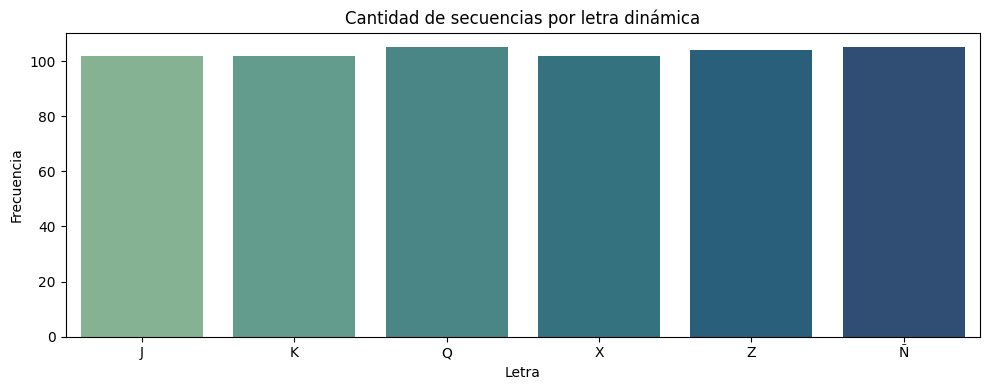

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 4))
sns.countplot(data=df, x="label", palette="crest")
plt.title("Cantidad de secuencias por letra dinámica")
plt.xlabel("Letra")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

## Duración de las secuencias (frames por gesto)

Calculamos cuántos frames tiene cada secuencia para detectar si hay mucha variabilidad en la duración de los clips.

In [17]:
df["n_frames"] = df["frames"].apply(len)
df["n_frames"].describe()

count    620.000000
mean      16.245161
std        4.883578
min        7.000000
25%       13.000000
50%       15.500000
75%       19.000000
max       38.000000
Name: n_frames, dtype: float64

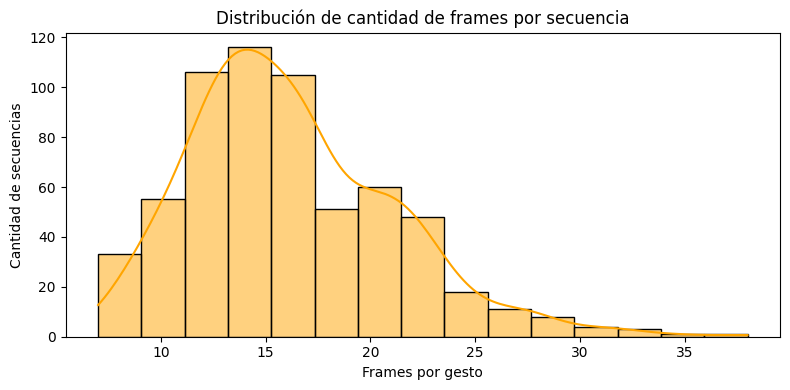

In [19]:
plt.figure(figsize=(8, 4))
sns.histplot(df["n_frames"], bins=15, kde=True, color="orange")
plt.title("Distribución de cantidad de frames por secuencia")
plt.xlabel("Frames por gesto")
plt.ylabel("Cantidad de secuencias")
plt.tight_layout()
plt.show()

## Verificación de integridad

Nos aseguramos de que los archivos de imagen mencionados realmente existan y se puedan acceder.

In [20]:
from tqdm import tqdm

missing = []
for paths in tqdm(df["frames"], desc="Verificando rutas"):
    for p in paths:
        if not (here() / p).exists():
            missing.append(p)

print(f"❌ Archivos perdidos: {len(missing)}")
if missing:
    print(missing[:5])

Verificando rutas: 100%|██████████| 620/620 [00:04<00:00, 126.05it/s]

❌ Archivos perdidos: 0


## Visualización de una secuencia por clase

Seleccionamos una secuencia aleatoria por letra y mostramos sus primeros frames para observar los gestos.

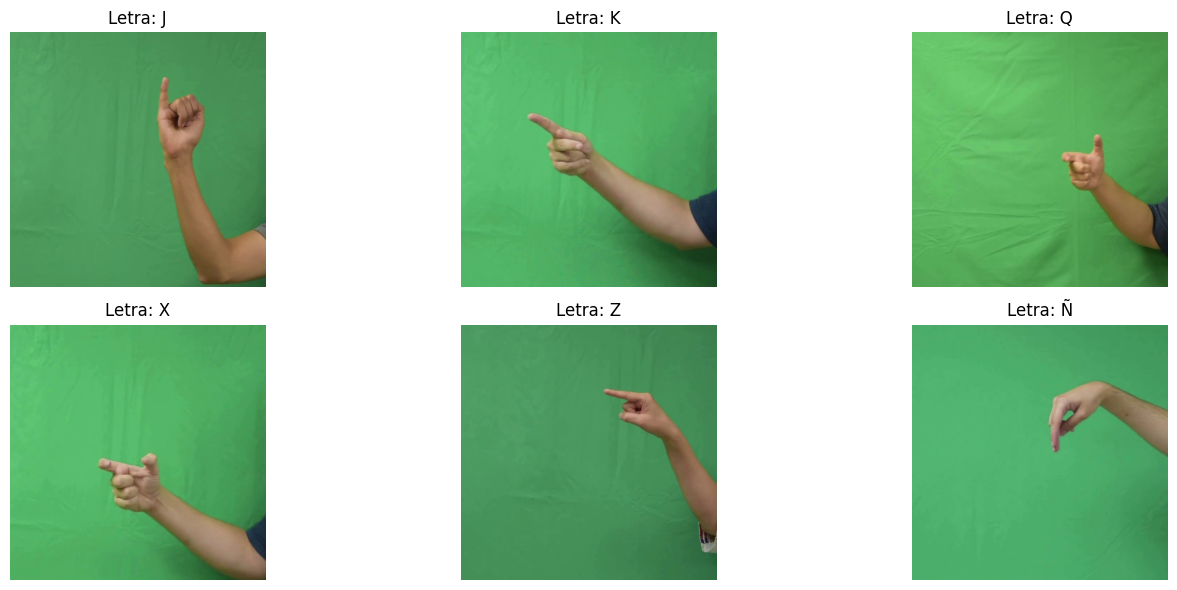

In [26]:
import numpy as np
import cv2

def imread_u8(p):
    buf = np.fromfile(p, dtype=np.uint8)          # Lee bytes (Unicode OK)
    return cv2.imdecode(buf, cv2.IMREAD_COLOR)    # Decodifica

letters = sorted(df["label"].unique())
fig, axes = plt.subplots(2, 3, figsize=(15, 6))
axes = axes.flatten()

for i, letra in enumerate(letters):
    frames = df[df["label"] == letra].sample(1).iloc[0]["frames"]
    frame_path = here() / Path(frames[min(2, len(frames)-1)])

    if not frame_path.exists():
        print(f"❌ No existe: {frame_path}")
        continue

    img = imread_u8(frame_path)
    if img is None:
        print(f"⚠️  OpenCV no pudo leer {frame_path}")
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
    axes[i].set_title(f"Letra: {letra}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Análisis de distribución mediante PCA + UMAP
Para explorar la separabilidad entre las clases dinámicas, se aplicó una reducción de dimensionalidad utilizando PCA (para reducir ruido) seguido de UMAP (para visualizar agrupamientos no lineales). Esto permite observar cómo se distribuyen las distintas letras dinámicas en un espacio bidimensional.

c:\Users\Jamin\miniconda3\envs\signml\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Jamin\miniconda3\envs\signml\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


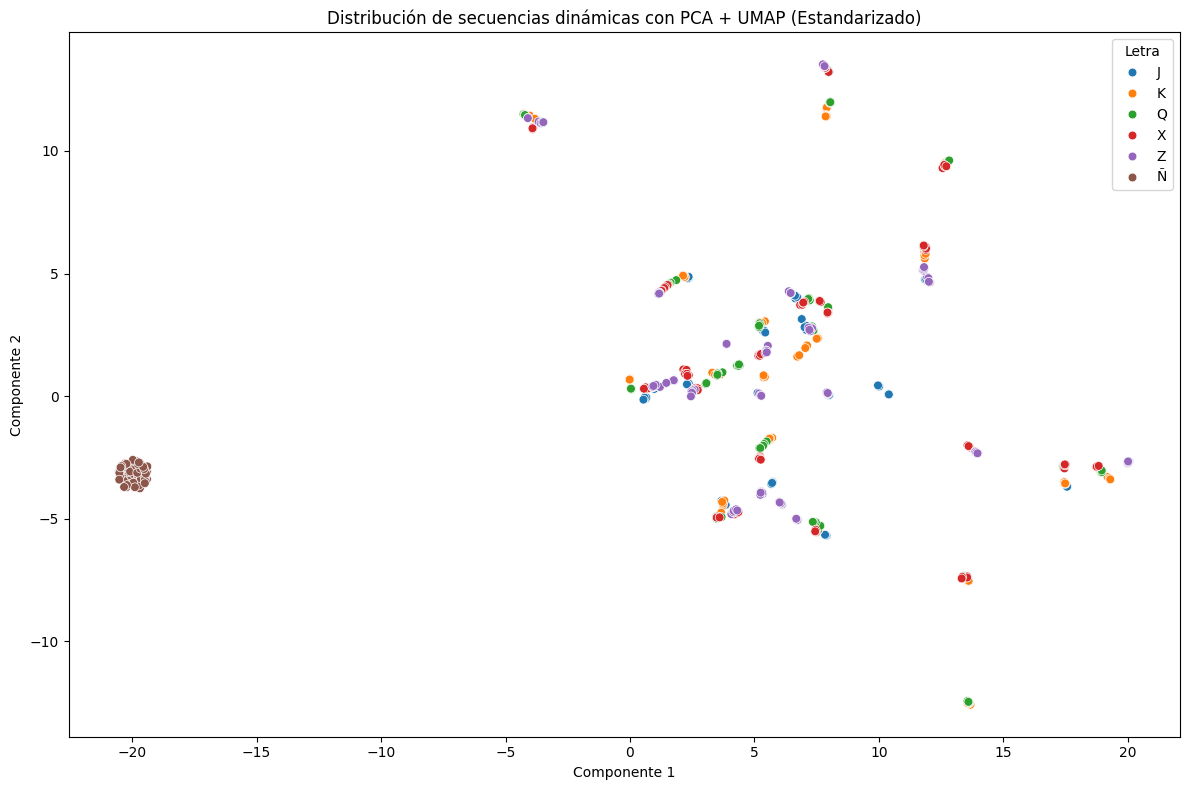

In [28]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap

# Vectorizar secuencias promediando los frames redimensionados
def vectorizar_secuencia(frame_paths):
    frames = [cv2.imread(str(here() / f)) for f in frame_paths]
    frames = [f for f in frames if f is not None]
    arr = np.array([cv2.resize(f, (64,64)).flatten() for f in frames])
    return arr.mean(axis=0) if len(arr) > 0 else np.zeros(64*64*3)

# Aplicar vectorización a todas las secuencias
X = np.vstack(df['frames'].apply(vectorizar_secuencia).to_list())
y = df['label'].to_numpy()

# 🔹 Estandarización antes de PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 🔸 Paso 1: PCA
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_scaled)

# 🔸 Paso 2: UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(X_pca)

# Crear DataFrame para visualización
df_umap = pd.DataFrame(X_umap, columns=['Componente 1', 'Componente 2'])
df_umap['Letra'] = y

# Visualización
plt.figure(figsize=(12,8))
sns.scatterplot(data=df_umap, x='Componente 1', y='Componente 2', hue='Letra', palette='tab10', s=40)
plt.title("Distribución de secuencias dinámicas con PCA + UMAP (Estandarizado)")
plt.legend(title="Letra")
plt.tight_layout()
plt.show()

## Conclusiones

- Se detectaron correctamente las 6 letras dinámicas del LSM: **J, K, Ñ, Q, X, Z**.
- Se extrajeron un total de **620 secuencias** de video, una cantidad equilibrada entre clases.
- La duración promedio de cada gesto es de aproximadamente **16 frames**, con valores entre 7 y 38.
- La distribución de frames por secuencia sigue una forma parecida a una distribución normal, con un ligero sesgo a la derecha.
- No se encontraron secuencias con rutas de imágenes perdidas o con errores de lectura.
- Se visualizó correctamente una muestra representativa de cada gesto dinámico.
- Se aplicó una reducción de dimensionalidad con **PCA + UMAP**, previa estandarización de las secuencias vectorizadas.
- La visualización en 2D mostró **una buena separación entre clases**, especialmente para la letra **Ñ**, que forma un grupo compacto y bien definido.

> Estos resultados confirman que el dataset dinámico está limpio, balanceado y visualmente interpretable, lo que permite su uso en modelos de aprendizaje profundo como **RNN**, **LSTM** o modelos con atención. La representación reducida también podría ser útil para tareas exploratorias o como preprocesamiento para clustering o clasificación.